In [1]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 39.2 MB/s 


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
import os
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from keras import regularizers
from tensorflow.python.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, accuracy_score, f1_score
import keras.backend as K
import matplotlib.pyplot as plt
import codecs
from tqdm import tqdm
from kerastuner import HyperParameters, Objective
%matplotlib inline
import seaborn as sns
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from ipykernel import kernelapp as app


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
os.chdir("/content/drive/MyDrive/TextAnalytics - AMI 2020/dataset")

In [5]:
## TRAINING SET
ami_csv = "training_set_cleaned.csv"
df = pd.read_csv(ami_csv)

In [ ]:
## TEST SET
ami_csv = "AMI2020_test_raw_gold_anon.tsv"
df_test = pd.read_csv(ami_csv, sep = "\t")

In [ ]:
df_test.head(3)

,id,text,misogynous,aggressiveness
0,5001,Aveva voglia di gridare tutta la mia rabbia ma...,0,0
1,5002,Lei è acida perché non ha figli penso che dare...,0,0
2,5003,Ma quanto è brutto sentirsi dire dal proprio f...,0,0


In [ ]:
df.head(2)

,text,misogynous,aggressiveness,target,final_text_wo_tag,final_text_tag
0,<mention_1> <mention_2> fatti trovare te lo d...,1,1,2,fare trovare do volentieri sborrare bocca,<mention> fare trovare do volentieri sborrare ...
1,<mention_1> tu dovresti ricominciare dai semaf...,1,1,2,dovresti ricominciare semafori fare lavavetri ...,<mention> dovresti ricominciare semafori fare ...


In [ ]:
## BEFORE SPLITTING 
# Percertage of misogynous tweets = 46.43%
# Percertage of non misogynous tweets = 53.57%

#Percertage of aggressive tweets = 35.59%
#Percertage of non aggressive tweets = 64.41%

In [76]:
def split_tokenize_padding(df, resample=False):

  ## SPLIT in Training Set and Validation Set stratify based on target variable
  train, val = train_test_split(df, 
                                stratify=df['target'],
                                test_size=0.2, random_state=42)
  
  if (resample):
    train_new = train.copy()
    temp_train = train_new.iloc[np.random.choice(np.where(train_new['target']==1)[0], size=1096)]
    train = train_new.append(temp_train, ignore_index=True)

  X_train = train["final_text_tag"]
  y_agr_train = train["aggressiveness"]
  y_mys_train = train["misogynous"]
  y_mlc_train = train["target"]

  X_val = val["final_text_tag"]
  y_agr_val = val["aggressiveness"]
  y_mys_val = val["misogynous"]
  y_mlc_val = val["target"]
  
  # we know from DU that most tweets have lenght of about 35, just very few exceed that len.
  # we can then perform a padding operation so that all tweets have same len of 35. 
  max_len = 35

  ## VAL SET
  tokenizer = Tokenizer()
  # populate a vocabulary of all unique tokens
  tokenizer.fit_on_texts(X_val)
  # tokenize each tweets into tokens and then retrieve indexes of those tokens from the vocabulary
  sequences = tokenizer.texts_to_sequences(X_val) 
  # padding to 35
  padsequences = pad_sequences(sequences, maxlen= max_len)
  X_val = padsequences

  ## TRAIN SET
  tokenizer = Tokenizer()
  # populate a vocabulary of all unique tokens
  tokenizer.fit_on_texts(X_train)
  # tokenize each tweets into tokens and then retrieve indexes of those tokens from the vocabulary
  sequences = tokenizer.texts_to_sequences(X_train) 
  padsequences = pad_sequences(sequences, maxlen= max_len)
  X_train = padsequences

  return tokenizer,X_train,X_val,y_mys_train,y_mys_val, y_agr_train, y_agr_val, y_mlc_train, y_mlc_val

In [7]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [9]:
tokenizer,X_train,X_val,y_mys_train,y_mys_val, y_agr_train, y_agr_val, y_mlc_train, y_mlc_val  = split_tokenize_padding(df)

In [10]:
size = len(y_mys_train[y_mys_train == 1])
print("Percertage of misogynous tweets Training Set = " + str(round((size/len(y_mys_train) * 100),2)))

size = len(y_mys_train[y_mys_train == 0])
print("Percertage of non misogynous tweets Training Set = " + str(round((size/len(y_mys_train) * 100),2)))
print("\t")
size = len(y_agr_train[y_agr_train == 1])
print("Percertage of aggressive tweets Training Set= " + str(round((size/len(y_agr_train) * 100),2)))

size = len(y_agr_train[y_agr_train == 0])
print("Percertage of non aggressive tweets Training Set= " + str(round((size/len(y_agr_train) * 100),2)))

Percertage of misogynous tweets Training Set = 46.42
Percertage of non misogynous tweets Training Set = 53.58
	
Percertage of aggressive tweets Training Set= 35.69
Percertage of non aggressive tweets Training Set= 64.31


In [ ]:
X_train

array([[   0,    0,    0, ..., 3061,    3,    2],
       [   0,    0,    0, ...,  989, 1819,  420],
       [   0,    0,    0, ..., 3062,  655, 3063],
       ...,
       [   0,    0,    0, ..., 1626, 1729, 8194],
       [   0,    0,    0, ...,    2,  575,    1],
       [   0,    0,    0, ...,   74,    3,    2]], dtype=int32)

## Build a CNN

In [11]:
#Global Parameters
max_len = 35
EPOCHS = 50
BATCH_SIZE= 128
EARLY_STOPPING_PATIENCE = 5 #If f1 does not increase after this epochs, break the process 
NUM_CLASSES = 1 

##### some utility functions

In [12]:
earlyStopper = EarlyStopping(monitor="val_loss", patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

In [13]:
# takes a tuner object as input to tune hyper-parameters

def tune_CNN(tuner):
  model = Sequential()

  # Embedding Layer
  model.add(Embedding(
        input_dim = vocab_len, 
        output_dim = embedding_len, 
        weights=[matrix_embedding], 
        input_length=max_len ,
        trainable=True))

  # First Convolution1D layer, RELU 
  model.add(Conv1D(tuner.Int("conv1", 
                             min_value=16, 
                             max_value=128, 
                             step=16), 
                   kernel_regularizer=tf.keras.regularizers.l2(
                    tuner.Float(
                      'regularizer_3',
                      min_value=1e-4,
                      max_value=1e-1,
                      sampling='LOG',
                      default=1e-2
                  )),
                   kernel_size=tuner.Int('kernel_size1',
                                      min_value=3,
                                      max_value=11,
                                      step = 2),
                   activation='relu')) 
  model.add(MaxPooling1D())
  model.add(Dropout(tuner.Float('drop2', 0, 0.5, step=0.1, default=0.5)))

  # Second Convolution1D layer, RELU 
  model.add(Conv1D(tuner.Int("conv2", 
                          min_value=32, 
                          max_value=144, 
                          step=32), 
                   kernel_regularizer=tf.keras.regularizers.l2(
                    tuner.Float(
                      'regularizer_4',
                      min_value=1e-4,
                      max_value=1e-1,
                      sampling='LOG',
                      default=1e-2
                  )),
                kernel_size=tuner.Int('kernel_size2',
                                    min_value=3,
                                    max_value=11,
                                    step = 2),
                activation='relu')) 
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(tuner.Float('drop3', 0, 0.5, step=0.1, default=0.5)))
  
  # Dense Layer 
  model.add(Dense(tuner.Int("dense1", min_value=64, max_value=128, step=32), 
                 kernel_regularizer=tf.keras.regularizers.l2(
                    tuner.Float(
                      'regularizer_1',
                      min_value=1e-4,
                      max_value=1e-1,
                      sampling='LOG',
                      default=1e-2
                  )),
                  activation='relu',
                  name='pre-classifier'))
  model.add(Dropout(tuner.Float('drop4', 0, 0.5, step=0.1, default=0.5)))

  # Sigmoid Classificator
  model.add(Dense(n_class, 
                  kernel_regularizer=tf.keras.regularizers.l2(
                    tuner.Float(
                      'regularizer_2',
                      min_value=1e-4,
                      max_value=1e-1,
                      sampling='LOG',
                      default=1e-2
                  )),
                  activation='sigmoid', name='classifier'))

  # Learning Rate initialization
  lr = tuner.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3])
  opt = keras.optimizers.Adam(learning_rate=lr)

  # Compile the model 
  if (n_class==3):
    model.compile(optimizer=opt, 
              loss="categorical_crossentropy", 
              metrics=["acc"])
  else:
    model.compile(optimizer=opt, 
          loss="binary_crossentropy", 
          metrics=[f1_score])
  
  model.summary()
  
  return model

In [14]:
def tuner_search_print(y_train,projectname,n_class=1):

  if (n_class == 3): 
    obj = 'val_acc'
  else:
    obj = 'val_f1_score'

  tuner = kt.Hyperband(hypermodel = tune_CNN,
                     objective = Objective(obj, direction='max'),
                     max_epochs = 50, directory='dataset/', seed=43,
                     project_name=projectname)
  
  tuner.search(X_train, y_train, epochs=EPOCHS, validation_split= 0.1, callbacks=[earlyStopper])

  # Get the optimal hyperparameters
  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
  print("Best value of conv1: {}".format(best_hps.get("conv1")))
  print("Best value of conv2: {}".format(best_hps.get("conv2")))

  print("Best value of kernel_size1: {}".format(best_hps.get("kernel_size1")))
  print("Best value of kernel_size2: {}".format(best_hps.get("kernel_size2")))

  #print("Best value of drop1: {}".format(best_hps.get("drop1")))
  print("Best value of drop2: {}".format(best_hps.get("drop2")))
  print("Best value of drop3: {}".format(best_hps.get("drop3")))
  print("Best value of drop4: {}".format(best_hps.get("drop4")))

  print("Best value of dense1: {}".format(best_hps.get("dense1")))
  print("Best value of LR: {:.4f}".format(best_hps.get("learning_rate")))

  print("Best value of regularizer_1: {:.4f}".format(best_hps.get("regularizer_1")))
  print("Best value of regularizer_2: {:.4f}".format(best_hps.get("regularizer_2")))

  return best_hps

In [15]:
def build_cnn(best_hps, n_class):
  model = Sequential()

  # Embedding Layer
  model.add(Embedding(
        input_dim = vocab_len, 
        output_dim = embedding_len, 
        weights=[matrix_embedding], 
        input_length=max_len ,
        trainable=True))

  # First Convolution1D layer, RELU 
  model.add(Conv1D(best_hps.get("conv1"), 
                   kernel_regularizer=tf.keras.regularizers.l2(best_hps.get("regularizer_1")),
                   kernel_size = best_hps.get("kernel_size1"), 
                   activation='relu')) 
  model.add(MaxPooling1D())
  model.add(Dropout(best_hps.get("drop2")))

  # Second Convolution1D layer, RELU 
  model.add(Conv1D(best_hps.get("conv2"),
                   kernel_regularizer=tf.keras.regularizers.l2(best_hps.get("regularizer_1")),
                   kernel_size = best_hps.get("kernel_size2"),
                activation='relu')) 
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(best_hps.get("drop3")))
  
  # Dense Layer 
  model.add(Dense(best_hps.get("dense1"), 
                  kernel_regularizer=tf.keras.regularizers.l2(best_hps.get("regularizer_1")),
                  activation='relu',name='pre-classifier'))
  model.add(Dropout(best_hps.get("drop4")))

  # sigmoid Classificator
  model.add(Dense(n_class,
                  kernel_regularizer=tf.keras.regularizers.l2(best_hps.get("regularizer_2")),
                  activation='sigmoid', name='classifier'))

  # Learning Rate 
  opt = keras.optimizers.Adam(learning_rate=best_hps.get("learning_rate"))
  
  # Compile the model 
  if (n_class==3):
    model.compile(optimizer=opt, 
              loss="categorical_crossentropy", 
              metrics=["acc"])
  else:
    model.compile(optimizer=opt, 
          loss="binary_crossentropy", 
          metrics=[f1_score])
  

  model.summary()
  
  return model

In [16]:
def plot_history(history):
    f1_score = history.history['f1_score']
    val_f1_score = history.history['val_f1_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(f1_score) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, f1_score, 'b', label='Training F1 Score')
    plt.plot(x, val_f1_score, 'r', label='Validation F1 Score')
    plt.title('Training and validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training Loss')
    plt.plot(x, val_loss, 'r', label='Validation Loss')
    plt.title('Training and validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend()

In [17]:
def eval_model(model,X_train,X_val,y_train,y_val):
  # Find train and test f1
  loss, f1 = model.evaluate(X_train, y_train, verbose=False)
  print("Training F1 Score: {:.4f}".format(f1))
  loss, f1 = model.evaluate(X_val, y_val, verbose=False)
  print("Validation F1 Score:  {:.4f}".format(f1))

  y_prob = model.predict(X_val)
  y_pred = y_prob.round()
  print(classification_report(y_val, y_pred))
  confusion_matrix(y_val, y_pred)

### Load Glove Embedding

In [54]:
# load Glove Embeddings in memory from the file
# we return a dictionary (glove_embeddings) whose keys are tokens and values are the embeddings

glove_dict = {}
with open("glove.6B.100d.txt") as f:
  for text in f:
        try:
            token = text.split()
            key = token[0]
            values = token[1:]
            glove_dict[key] = np.array(values, dtype=np.float32)
        except:
            continue
f.close()

Create a matrix of Glove Embedding for words in the training set. We loop over word_index (which are unique words in the set) and their respective index. We then set a numpy array filled with values from glove dictionary and build our matrix, which contains only values(weight) for the words in our training set.


In [55]:
# build matrix Of GloVe embeddings
def build_matrixGlove():
  embedding_len = 100
  vocab_len = len(tokenizer.index_word) + 1

  matrix_embedding = np.zeros((vocab_len, embedding_len))

  # vocabulary tokens (tweets)
  word_index = tokenizer.word_index

  word_index

  for word , idx in word_index.items():
    # retrive word from glove_dict and put it in the matrix, if it is not present then it return a numpy array with embedding len zeros
    matrix_embedding[idx] = glove_dict.get(word, np.zeros(embedding_len))
  return matrix_embedding, embedding_len, vocab_len

In [77]:
matrix_embedding, embedding_len, vocab_len = build_matrixGlove()

### tuning CNN + Glove Embedding

In [26]:
n_class = 1

In [78]:
best_hps = tuner_search_print(y_mys_train,'hyperband_tuner2')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 35, 100)           819600    
                                                                 
 conv1d_26 (Conv1D)          (None, 33, 16)            4816      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 16, 16)           0         
 g1D)                                                            
                                                                 
 dropout_39 (Dropout)        (None, 16, 16)            0         
                                                                 
 conv1d_27 (Conv1D)          (None, 14, 32)            1568      
                                                                 
 global_max_pooling1d_13 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                   

### build  CNN + Glove Embedding

In [79]:
model = build_cnn(best_hps, 1)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 35, 100)           819600    
                                                                 
 conv1d_28 (Conv1D)          (None, 27, 32)            28832     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 13, 32)           0         
 g1D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 13, 32)            0         
                                                                 
 conv1d_29 (Conv1D)          (None, 9, 96)             15456     
                                                                 
 global_max_pooling1d_14 (Gl  (None, 96)               0         
 obalMaxPooling1D)                                   

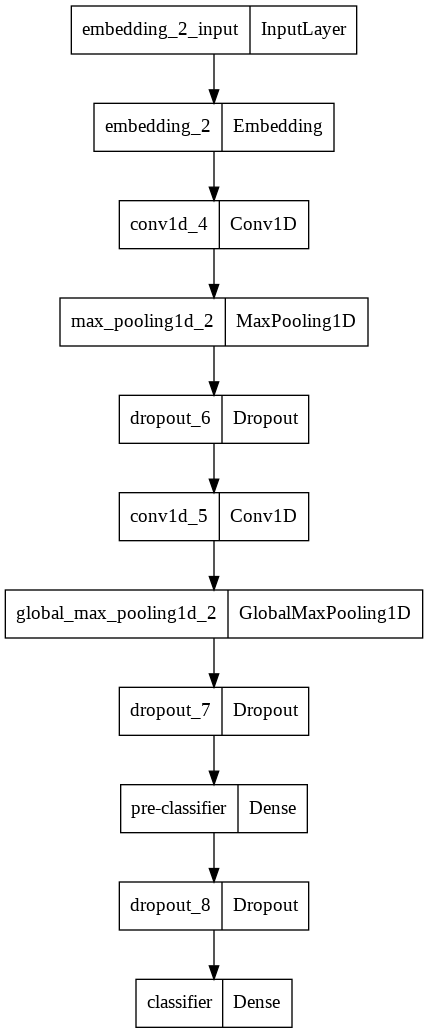

In [ ]:
tf.keras.utils.plot_model(model)

In [80]:
batch_size=128

model_fit = model.fit(X_train, y_mys_train,
          validation_split = 0.1,
          batch_size=batch_size,
          epochs=EPOCHS, callbacks=[earlyStopper])

Epoch 1/50
33/33 [==============================] - 3s 53ms/step - loss: 0.6626 - f1_score: 0.7081 - val_loss: 0.4868 - val_f1_score: 0.8632
Epoch 2/50
33/33 [==============================] - 1s 45ms/step - loss: 0.5417 - f1_score: 0.7714 - val_loss: 0.2455 - val_f1_score: 0.9671
Epoch 3/50
33/33 [==============================] - 1s 44ms/step - loss: 0.3703 - f1_score: 0.8685 - val_loss: 0.1139 - val_f1_score: 0.9832
Epoch 4/50
33/33 [==============================] - 1s 44ms/step - loss: 0.2361 - f1_score: 0.9286 - val_loss: 0.0745 - val_f1_score: 0.9925
Epoch 5/50
33/33 [==============================] - 1s 44ms/step - loss: 0.1514 - f1_score: 0.9601 - val_loss: 0.0585 - val_f1_score: 0.9990
Epoch 6/50
33/33 [==============================] - 1s 44ms/step - loss: 0.1043 - f1_score: 0.9772 - val_loss: 0.0332 - val_f1_score: 1.0000
Epoch 7/50
33/33 [==============================] - 2s 46ms/step - loss: 0.0717 - f1_score: 0.9889 - val_loss: 0.0314 - val_f1_score: 1.0000
Epoch 8/50
33

In [ ]:
model_fit.history

{'loss': [0.6947741508483887,
  0.6113914251327515,
  0.5058751106262207,
  0.3424733281135559,
  0.2302693873643875,
  0.16230309009552002,
  0.11931219696998596,
  0.09079496562480927,
  0.07069623470306396,
  0.05655013397336006],
 'f1_score': [0.3853488862514496,
  0.6855517625808716,
  0.7536271810531616,
  0.86208575963974,
  0.9243863821029663,
  0.9488540887832642,
  0.9713078141212463,
  0.9767338037490845,
  0.9858852624893188,
  0.991666853427887],
 'val_loss': [0.6617041230201721,
  0.6100578308105469,
  0.5387435555458069,
  0.5278559327125549,
  0.5040892958641052,
  0.5150589346885681,
  0.5544416904449463,
  0.6335840225219727,
  0.6979424953460693,
  0.7442131638526917],
 'val_f1_score': [0.6629504561424255,
  0.699748694896698,
  0.7594413161277771,
  0.7988131046295166,
  0.8226819038391113,
  0.8195272088050842,
  0.8254678845405579,
  0.8177700042724609,
  0.8251206874847412,
  0.8246334195137024]}

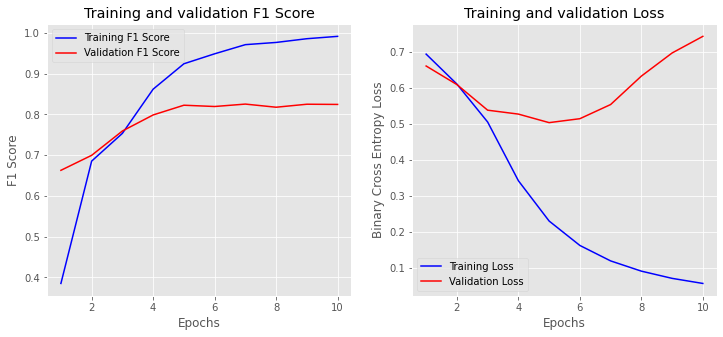

In [ ]:
plot_history(model_fit)

Training F1 Score: 0.9986
Validation F1 Score:  0.6966
              precision    recall  f1-score   support

           0       0.76      0.65      0.70       471
           1       0.65      0.76      0.70       409

    accuracy                           0.70       880
   macro avg       0.71      0.71      0.70       880
weighted avg       0.71      0.70      0.70       880



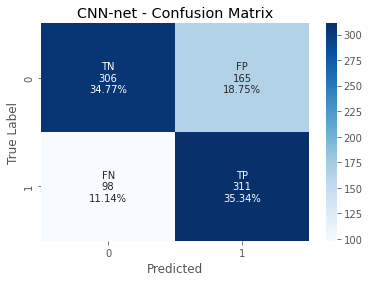

In [81]:
# Find train and test f1
loss, f1 = model.evaluate(X_train, y_mys_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val, y_mys_val, verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

y_prob = model.predict(X_val)
y_pred_mys = y_prob.round()
                    
print(classification_report(y_mys_val, y_pred_mys))
confusion_matrix(y_mys_val, y_pred_mys)

cf_matrix = confusion_matrix(y_mys_val, y_pred_mys)
make_confusion_matrix(cf_matrix, 'CNN-net - Confusion Matrix')

### CNN + Glove Agressive

In [82]:
best_hps = tuner_search_print(y_agr_train,'hyperband_tuner3')

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 35, 100)           819600    
                                                                 
 conv1d_30 (Conv1D)          (None, 33, 16)            4816      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 16, 16)           0         
 g1D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 16, 16)            0         
                                                                 
 conv1d_31 (Conv1D)          (None, 14, 32)            1568      
                                                                 
 global_max_pooling1d_15 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                   

In [83]:
model = build_cnn(best_hps, 1)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 35, 100)           819600    
                                                                 
 conv1d_32 (Conv1D)          (None, 33, 80)            24080     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 16, 80)           0         
 g1D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 16, 80)            0         
                                                                 
 conv1d_33 (Conv1D)          (None, 14, 32)            7712      
                                                                 
 global_max_pooling1d_16 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                   

In [ ]:
print(X_train.shape)
print(y_agr_train.shape)
print(y_mys_train.shape)

(3516, 35)
(3516,)
(3516,)


In [85]:
batch_size=128

model_fit = model.fit(X_train, y_agr_train,
          validation_split = 0.1,
          batch_size=batch_size,
          epochs=EPOCHS, callbacks=[earlyStopper])

Epoch 1/50
33/33 [==============================] - 1s 42ms/step - loss: 0.4808 - f1_score: 0.8699 - val_loss: 0.3992 - val_f1_score: 0.9246
Epoch 2/50
33/33 [==============================] - 1s 42ms/step - loss: 0.1714 - f1_score: 0.9668 - val_loss: 0.1573 - val_f1_score: 0.9908
Epoch 3/50
33/33 [==============================] - 1s 42ms/step - loss: 0.1161 - f1_score: 0.9833 - val_loss: 0.1354 - val_f1_score: 0.9945
Epoch 4/50
33/33 [==============================] - 1s 42ms/step - loss: 0.0967 - f1_score: 0.9886 - val_loss: 0.1110 - val_f1_score: 0.9971
Epoch 5/50
33/33 [==============================] - 1s 41ms/step - loss: 0.0878 - f1_score: 0.9911 - val_loss: 0.0704 - val_f1_score: 0.9971
Epoch 6/50
33/33 [==============================] - 1s 42ms/step - loss: 0.0794 - f1_score: 0.9933 - val_loss: 0.0606 - val_f1_score: 1.0000
Epoch 7/50
33/33 [==============================] - 1s 41ms/step - loss: 0.0719 - f1_score: 0.9939 - val_loss: 0.0576 - val_f1_score: 1.0000
Epoch 8/50
33

In [73]:
plot_history(model_fit)

In [ ]:
y_agr_val

309     1
2643    0
2635    0
0       1
3461    0
       ..
1492    1
2931    0
4186    0
2769    0
2891    0
Name: aggressiveness, Length: 880, dtype: int64

Training F1 Score: 0.6542
Validation F1 Score:  0.5978
              precision    recall  f1-score   support

           0       0.80      0.67      0.73       566
           1       0.54      0.70      0.61       314

    accuracy                           0.68       880
   macro avg       0.67      0.69      0.67       880
weighted avg       0.71      0.68      0.69       880



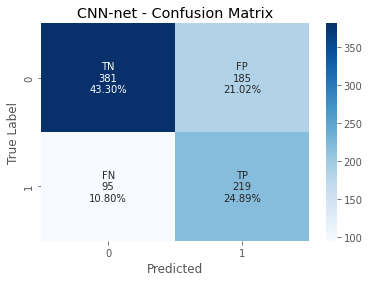

In [86]:
# Find train and test f1
loss, f1 = model.evaluate(X_train, y_agr_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val, y_agr_val, verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

y_prob = model.predict(X_val)
y_pred = y_prob.round()
                    
print(classification_report(y_agr_val, y_pred))
confusion_matrix(y_agr_val, y_pred)

cf_matrix = confusion_matrix(y_agr_val, y_pred)
make_confusion_matrix(cf_matrix, 'CNN-net - Confusion Matrix')

In [87]:
## second testing strategy
itemindex = np.where(y_pred_mys == 1)
X_val_agr = X_val[itemindex[0]]
y_prob = model.predict(X_val_agr)
y_pred_agr = y_prob.round()
y_agr_val.reset_index(inplace=True, drop=True)                    

# Find train and test f1
loss, f1 = model.evaluate(X_train, y_agr_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val_agr, y_agr_val[itemindex[0]], verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

print(classification_report(y_agr_val[itemindex[0]], y_pred_agr))
confusion_matrix(y_agr_val[itemindex[0]], y_pred_agr)

cf_matrix = confusion_matrix(y_agr_val[itemindex[0]], y_pred_agr)

Training F1 Score: 0.6542
Validation F1 Score:  0.6694
              precision    recall  f1-score   support

           0       0.69      0.33      0.45       238
           1       0.56      0.85      0.67       238

    accuracy                           0.59       476
   macro avg       0.62      0.59      0.56       476
weighted avg       0.62      0.59      0.56       476



### CNN + Glove Multiclass

In [88]:
n_class = 3

In [89]:
tokenizer,X_train,X_val,y_mys_train,y_mys_val, y_agr_train, y_agr_val, y_mlc_train, y_mlc_val = split_tokenize_padding(df,True)

In [90]:
matrix_embedding, embedding_len, vocab_len  = build_matrixGlove()

In [ ]:
print(sorted(Counter(y_mlc_train).items()))

[(0, 1649), (1, 1426), (2, 1098)]


In [ ]:
print(sorted(Counter(y_mlc_val).items()))

[(0, 706), (1, 142), (2, 471)]


In [91]:
y_mlc_train = to_categorical(y_mlc_train, num_classes=n_class)
y_mlc_val = to_categorical(y_mlc_val, num_classes=n_class)

In [92]:
earlyStopper = EarlyStopping(monitor="val_loss", patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

In [93]:
best_hps = tuner_search_print(y_mlc_train,'hyperband_tunermlc')

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 35, 100)           885500    
                                                                 
 conv1d_34 (Conv1D)          (None, 33, 16)            4816      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 16, 16)           0         
 g1D)                                                            
                                                                 
 dropout_51 (Dropout)        (None, 16, 16)            0         
                                                                 
 conv1d_35 (Conv1D)          (None, 14, 32)            1568      
                                                                 
 global_max_pooling1d_17 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                   

In [94]:
model = build_cnn(best_hps, n_class)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 35, 100)           885500    
                                                                 
 conv1d_36 (Conv1D)          (None, 31, 48)            24048     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 15, 48)           0         
 g1D)                                                            
                                                                 
 dropout_54 (Dropout)        (None, 15, 48)            0         
                                                                 
 conv1d_37 (Conv1D)          (None, 13, 96)            13920     
                                                                 
 global_max_pooling1d_18 (Gl  (None, 96)               0         
 obalMaxPooling1D)                                   

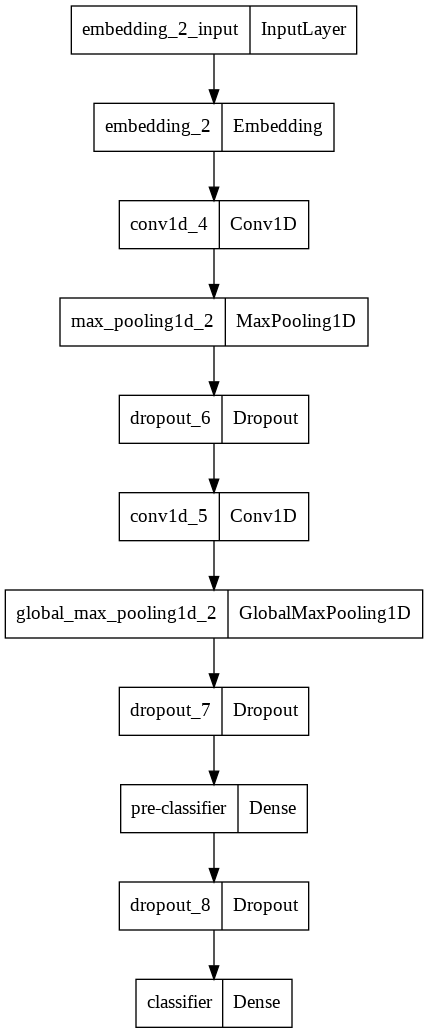

In [ ]:
tf.keras.utils.plot_model(model)

In [95]:
batch_size=128

model_fit = model.fit(X_train, y_mlc_train,
          validation_split = 0.10,
          batch_size=batch_size,
          epochs=EPOCHS, callbacks=[earlyStopper])

Epoch 1/50
36/36 [==============================] - 6s 75ms/step - loss: 10.2015 - acc: 0.4666 - val_loss: 6.8051 - val_acc: 0.0000e+00
Epoch 2/50
36/36 [==============================] - 2s 59ms/step - loss: 4.5800 - acc: 0.4677 - val_loss: 3.4745 - val_acc: 0.0000e+00
Epoch 3/50
36/36 [==============================] - 2s 59ms/step - loss: 2.3689 - acc: 0.4661 - val_loss: 2.2086 - val_acc: 0.0000e+00
Epoch 4/50
36/36 [==============================] - 2s 59ms/step - loss: 1.5285 - acc: 0.4663 - val_loss: 1.7621 - val_acc: 0.0000e+00
Epoch 5/50
36/36 [==============================] - 2s 56ms/step - loss: 1.1474 - acc: 0.5893 - val_loss: 1.5286 - val_acc: 0.0000e+00
Epoch 6/50
36/36 [==============================] - 2s 54ms/step - loss: 0.9055 - acc: 0.6716 - val_loss: 1.3074 - val_acc: 0.0000e+00
Epoch 7/50
36/36 [==============================] - 2s 64ms/step - loss: 0.7951 - acc: 0.6945 - val_loss: 1.1644 - val_acc: 0.0000e+00
Epoch 8/50
36/36 [==============================] - 2s

In [52]:
#plot_history(model_fit)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [96]:
# Find train and test f1
loss, f1 = model.evaluate(X_train, y_mlc_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val, y_mlc_val, verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))


# y_pred = np.argmax(model.predict(X_val), axis=-1)
y_prob = model.predict(X_val)
y_pred = y_prob.round()

print(classification_report(y_mlc_val, y_pred))

Training F1 Score: 0.9224
Validation F1 Score:  0.6045
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       236
           1       0.19      0.55      0.28        47
           2       0.36      1.00      0.53       157

   micro avg       0.46      0.84      0.59       440
   macro avg       0.45      0.78      0.53       440
weighted avg       0.58      0.84      0.65       440
 samples avg       0.46      0.84      0.59       440



### Fast Text Embedding Word

In [ ]:
n_class = 1

In [ ]:
embeddings_index = {}
f = codecs.open('cc.it.300.vec', encoding='utf-8')
for line in tqdm(f):
  try:
    token = line.rstrip().rsplit(' ')
    key = token[0]
    values = np.asarray(token[1:], dtype='float32')
    embeddings_index[key] = values
  except:
    continue
f.close()

print('found %s word vectors' % len(embeddings_index))

2000001it [03:38, 9146.37it/s]

found 2000000 word vectors


In [ ]:
tokenizer,X_train,X_val,y_mys_train,y_mys_val, y_agr_train, y_agr_val, y_mlc_train, y_mlc_val = split_tokenize_padding(df,False)

In [ ]:
# build matrix Of FastText embeddings
def buildMatrixFastText():
  embedding_len = 300
  vocab_len = len(tokenizer.index_word) + 1

  matrix_embedding = np.zeros((vocab_len, embedding_len))

  # vocabulary tokens (tweets)
  word_index = tokenizer.word_index
  w_not_found = []
  for word , idx in word_index.items():
    # retrive word from fasttest_dict and put it in the matrix, if it is not present then it return a numpy array with embedding len zeros
    is_found = embeddings_index.get(word)
    matrix_embedding[idx] = embeddings_index.get(word, np.zeros(embedding_len))
    if (is_found is None):
      # is a list of words not found 
      w_not_found.append(word)

  print('List of words not found in embeddings_index: %d' % len(w_not_found))
  return matrix_embedding, vocab_len, embedding_len


### cnn fast text for mys task

In [ ]:
best_hps = tuner_search_print(y_mys_train,'hyperband_tuner_ftmys2')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 35, 300)           2257500   
                                                                 
 conv1d_16 (Conv1D)          (None, 33, 16)            14416     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 16, 16)           0         
 1D)                                                             
                                                                 
 dropout_24 (Dropout)        (None, 16, 16)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 14, 32)            1568      
                                                                 
 global_max_pooling1d_8 (Glo  (None, 32)               0         
 balMaxPooling1D)                                     

In [ ]:
model = build_cnn(best_hps, 1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 35, 300)           2257500   
                                                                 
 conv1d_18 (Conv1D)          (None, 33, 112)           100912    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 16, 112)          0         
 1D)                                                             
                                                                 
 dropout_27 (Dropout)        (None, 16, 112)           0         
                                                                 
 conv1d_19 (Conv1D)          (None, 10, 96)            75360     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 96)               0         
 balMaxPooling1D)                                     

In [ ]:
batch_size=128

model_fit = model.fit(X_train, y_mys_train,
          validation_split = 0.1,
          batch_size=batch_size,
          epochs=EPOCHS, callbacks=[earlyStopper])

Epoch 1/50
22/22 [==============================] - 5s 174ms/step - loss: 1.1415 - f1_score: 0.2189 - val_loss: 1.0076 - val_f1_score: 0.6523
Epoch 2/50
22/22 [==============================] - 3s 157ms/step - loss: 0.8363 - f1_score: 0.7695 - val_loss: 0.7291 - val_f1_score: 0.8287
Epoch 3/50
22/22 [==============================] - 3s 156ms/step - loss: 0.5768 - f1_score: 0.8859 - val_loss: 0.6010 - val_f1_score: 0.8548
Epoch 4/50
22/22 [==============================] - 3s 158ms/step - loss: 0.4084 - f1_score: 0.9338 - val_loss: 0.5581 - val_f1_score: 0.8478
Epoch 5/50
22/22 [==============================] - 4s 159ms/step - loss: 0.2974 - f1_score: 0.9689 - val_loss: 0.5843 - val_f1_score: 0.8589
Epoch 6/50
22/22 [==============================] - 3s 158ms/step - loss: 0.2291 - f1_score: 0.9801 - val_loss: 0.6264 - val_f1_score: 0.8343
Epoch 7/50
22/22 [==============================] - 4s 160ms/step - loss: 0.1891 - f1_score: 0.9869 - val_loss: 0.6531 - val_f1_score: 0.8521
Epoch 

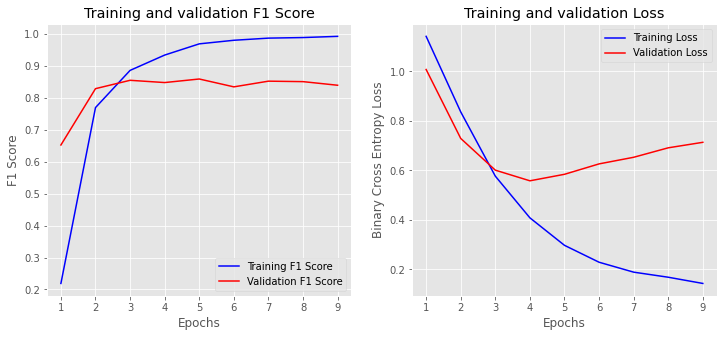

In [ ]:
plot_history(model_fit)

Training F1 Score: 0.9528
Validation F1 Score:  0.7683
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       706
           1       0.79      0.75      0.77       613

    accuracy                           0.79      1319
   macro avg       0.79      0.79      0.79      1319
weighted avg       0.79      0.79      0.79      1319



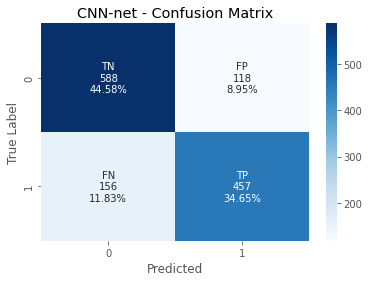

In [ ]:
# Find train and test f1
loss, f1 = model.evaluate(X_train, y_mys_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val, y_mys_val, verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

y_prob = model.predict(X_val)
y_pred_mys = y_prob.round()
                    
print(classification_report(y_mys_val, y_pred_mys))
confusion_matrix(y_mys_val, y_pred_mys)

cf_matrix = confusion_matrix(y_mys_val, y_pred_mys)
make_confusion_matrix(cf_matrix, 'CNN-net - Confusion Matrix')

### cnn fast text for agr task

In [ ]:
best_hps = tuner_search_print(y_agr_train,'hyperband_tuner_ftagr2')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 300)           2458800   
                                                                 
 conv1d (Conv1D)             (None, 33, 16)            14416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 16)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 32)            1568      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                         

In [ ]:
model = build_cnn(best_hps, 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 300)           2458800   
                                                                 
 conv1d_2 (Conv1D)           (None, 31, 16)            24016     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 16)           0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 16)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 13, 64)            3136      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                     

In [ ]:
model_fit = model.fit(X_train, y_agr_train,
            validation_split = 0.1,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, callbacks=[earlyStopper])

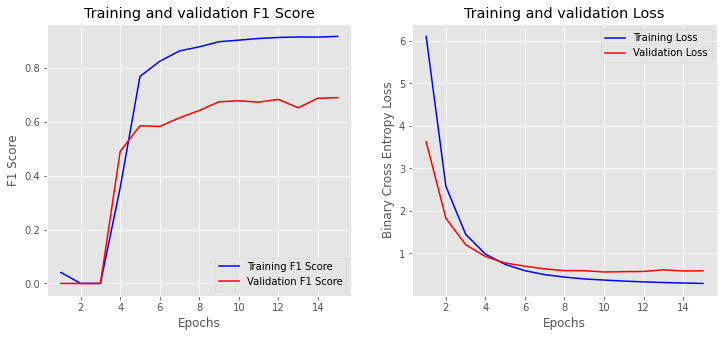

In [ ]:
plot_history(model_fit)

Training F1 Score: 0.8863
Validation F1 Score:  0.6015
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       566
           1       0.65      0.57      0.61       314

    accuracy                           0.74       880
   macro avg       0.72      0.70      0.71       880
weighted avg       0.73      0.74      0.73       880



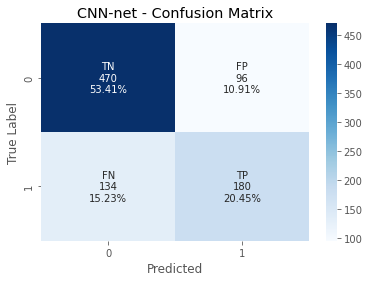

In [ ]:
# Find train and test f1
loss, f1 = model.evaluate(X_train, y_agr_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val, y_agr_val, verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

y_prob = model.predict(X_val)
y_pred = y_prob.round()
                    
print(classification_report(y_agr_val, y_pred))
confusion_matrix(y_agr_val, y_pred)

cf_matrix = confusion_matrix(y_agr_val, y_pred)
make_confusion_matrix(cf_matrix, 'CNN-net - Confusion Matrix')

Training F1 Score: 0.8863
Validation F1 Score:  0.7519
              precision    recall  f1-score   support

           0       0.57      0.20      0.30       104
           1       0.65      0.91      0.76       169

    accuracy                           0.64       273
   macro avg       0.61      0.55      0.53       273
weighted avg       0.62      0.64      0.58       273



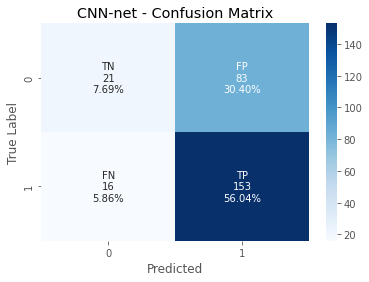

In [ ]:
## second testing strategy
itemindex = np.where(y_pred_mys == 1)
X_val_agr = X_val[itemindex[0]]
y_prob = model.predict(X_val_agr)
y_pred_agr = y_prob.round()
y_agr_val.reset_index(inplace=True, drop=True)                    

# Find train and test f1
loss, f1 = model.evaluate(X_train, y_agr_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val_agr, y_agr_val[itemindex[0]], verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

print(classification_report(y_agr_val[itemindex[0]], y_pred_agr))
confusion_matrix(y_agr_val[itemindex[0]], y_pred_agr)

cf_matrix = confusion_matrix(y_agr_val[itemindex[0]], y_pred_agr)

make_confusion_matrix(cf_matrix, 'CNN-net - Confusion Matrix')

### fast multiclass

In [ ]:
n_class = 3

In [ ]:
tokenizer,X_train,X_val,y_mys_train,y_mys_val, y_agr_train, y_agr_val, y_mlc_train, y_mlc_val = split_tokenize_padding(df,True)

In [ ]:
matrix_embedding, vocab_len, embedding_len = buildMatrixFastText()

List of words not found in embeddings_index: 672


In [ ]:
earlyStopper = EarlyStopping(monitor="val_loss", patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

In [ ]:
y_mlc_train = to_categorical(y_mlc_train, num_classes=n_class)
y_mlc_val = to_categorical(y_mlc_val, num_classes=n_class)

In [ ]:
best_hps = tuner_search_print(y_mlc_train,'hyperband_tunermlc')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 300)           2458800   
                                                                 
 conv1d_6 (Conv1D)           (None, 33, 16)            14416     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 16, 16)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 14, 32)            1568      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 32)               0         
 balMaxPooling1D)                                     

In [ ]:
model = build_cnn(best_hps, n_class)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 300)           2458800   
                                                                 
 conv1d_4 (Conv1D)           (None, 31, 48)            72048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 15, 48)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 48)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 13, 96)            13920     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 96)               0         
 balMaxPooling1D)                                     

In [ ]:
batch_size=128

model_fit = model.fit(X_train, y_mlc_train,
          validation_split = 0.10,
          batch_size=batch_size,
          epochs=EPOCHS, callbacks=[earlyStopper])

Epoch 1/50
33/33 [==============================] - 5s 116ms/step - loss: 10.4440 - acc: 0.4354 - val_loss: 6.5540 - val_acc: 0.0000e+00
Epoch 2/50
33/33 [==============================] - 4s 107ms/step - loss: 4.5582 - acc: 0.4540 - val_loss: 3.5094 - val_acc: 0.0000e+00
Epoch 3/50
33/33 [==============================] - 3s 105ms/step - loss: 2.4263 - acc: 0.5214 - val_loss: 2.2365 - val_acc: 0.0000e+00
Epoch 4/50
33/33 [==============================] - 3s 104ms/step - loss: 1.4671 - acc: 0.6612 - val_loss: 1.6306 - val_acc: 0.0000e+00
Epoch 5/50
33/33 [==============================] - 4s 106ms/step - loss: 1.0315 - acc: 0.6933 - val_loss: 1.3298 - val_acc: 0.0000e+00
Epoch 6/50
33/33 [==============================] - 4s 108ms/step - loss: 0.8271 - acc: 0.7058 - val_loss: 1.1732 - val_acc: 0.0000e+00
Epoch 7/50
33/33 [==============================] - 3s 106ms/step - loss: 0.7312 - acc: 0.7152 - val_loss: 1.0960 - val_acc: 0.0000e+00
Epoch 8/50
33/33 [=============================

In [ ]:
# Find train and test f1
loss, f1 = model.evaluate(X_train, y_mlc_train, verbose=False)
print("Training Accuracy Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val, y_mlc_val, verbose=False)
print("Validation Accuracy Score:  {:.4f}".format(f1))


# y_pred = np.argmax(model.predict(X_val), axis=-1)
y_prob = model.predict(X_val)
y_pred = y_prob.round()

print(classification_report(y_mlc_val, y_pred))

Training Accuracy Score: 0.9441
Validation Accuracy Score:  0.6580
              precision    recall  f1-score   support

           0       0.74      0.86      0.79       471
           1       0.20      0.38      0.26        95
           2       0.36      1.00      0.53       314

   micro avg       0.47      0.86      0.61       880
   macro avg       0.43      0.75      0.53       880
weighted avg       0.54      0.86      0.64       880
 samples avg       0.47      0.86      0.60       880



## BenchMark

In [ ]:
tokenizer,X_train,X_val,y_mys_train,y_mys_val, y_agr_train, y_agr_val, y_mlc_train, y_mlc_val = split_tokenize_padding(df)

In [ ]:
embedding_len = 100
vocab_len = len(tokenizer.index_word) + 1

In [ ]:
def build_cnn_bench(n_class):
  model = Sequential()

  # Embedding Layer
  model.add(Embedding(
        input_dim = vocab_len, 
        output_dim = embedding_len, 
        input_length=35 ,
        trainable=True))

  # First Convolution1D layer, RELU 
  model.add(Conv1D(48, kernel_size = 3, activation='relu'))

  model.add(MaxPooling1D())
  model.add(Dropout(0.3))
  model.add(Flatten())

  # sigmoid Classificator
  model.add(Dense(n_class,
                  activation='sigmoid', name='classifier'))

  # Learning Rate 
  opt = keras.optimizers.Adam()
  
  # Compile the model 
  if (n_class==3):
    model.compile(optimizer=opt, 
              loss="categorical_crossentropy", 
              metrics=["acc"])
  else:
    model.compile(optimizer=opt, 
          loss="binary_crossentropy", 
          metrics=[f1_score])
  
  model.summary()
  
  return model

In [ ]:
n_class = 1

In [ ]:
model = build_cnn_bench(n_class)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 100)           819600    
                                                                 
 conv1d_2 (Conv1D)           (None, 33, 32)            9632      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 16, 32)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 16, 32)            0         
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 classifier (Dense)          (None, 1)                 513       
                                                      

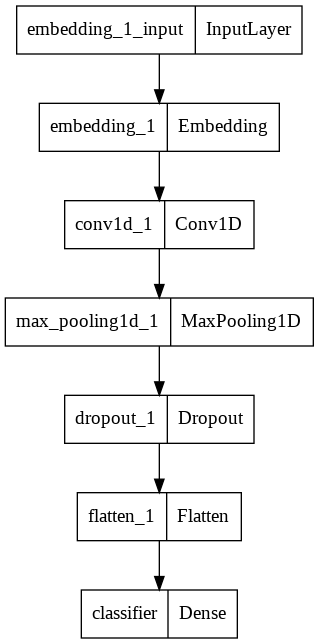

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model_fit = model.fit(X_train, y_mys_train,
            validation_split = 0.1,
            batch_size=BATCH_SIZE,
            epochs=30, callbacks=[earlyStopper])

Epoch 1/30
33/33 [==============================] - 3s 35ms/step - loss: 0.6648 - f1_score: 0.6956 - val_loss: 0.4830 - val_f1_score: 0.9964
Epoch 2/30
33/33 [==============================] - 1s 28ms/step - loss: 0.5179 - f1_score: 0.8355 - val_loss: 0.3297 - val_f1_score: 0.9801
Epoch 3/30
33/33 [==============================] - 1s 35ms/step - loss: 0.2908 - f1_score: 0.9069 - val_loss: 0.1490 - val_f1_score: 0.9901
Epoch 4/30
33/33 [==============================] - 1s 35ms/step - loss: 0.1791 - f1_score: 0.9447 - val_loss: 0.1038 - val_f1_score: 0.9911
Epoch 5/30
33/33 [==============================] - 1s 32ms/step - loss: 0.1198 - f1_score: 0.9682 - val_loss: 0.0549 - val_f1_score: 0.9951
Epoch 6/30
33/33 [==============================] - 1s 27ms/step - loss: 0.0812 - f1_score: 0.9768 - val_loss: 0.0403 - val_f1_score: 0.9951
Epoch 7/30
33/33 [==============================] - 1s 28ms/step - loss: 0.0569 - f1_score: 0.9861 - val_loss: 0.0282 - val_f1_score: 0.9980
Epoch 8/30
33

In [ ]:
model_fit = model.fit(X_train, y_mys_train,
            validation_split = 0.1,
            batch_size=BATCH_SIZE,
            epochs=30, callbacks=[earlyStopper])

Epoch 1/30
25/25 [==============================] - 1s 58ms/step - loss: 0.1775 - f1_score: 0.9185 - val_loss: 0.3540 - val_f1_score: 0.8451
Epoch 2/30
25/25 [==============================] - 1s 34ms/step - loss: 0.0970 - f1_score: 0.9675 - val_loss: 0.3642 - val_f1_score: 0.8497
Epoch 3/30
25/25 [==============================] - 1s 35ms/step - loss: 0.0681 - f1_score: 0.9788 - val_loss: 0.3735 - val_f1_score: 0.8613
Epoch 4/30
25/25 [==============================] - 1s 35ms/step - loss: 0.0506 - f1_score: 0.9863 - val_loss: 0.3958 - val_f1_score: 0.8564
Epoch 5/30
25/25 [==============================] - 1s 34ms/step - loss: 0.0417 - f1_score: 0.9881 - val_loss: 0.4195 - val_f1_score: 0.8594
Epoch 6/30
25/25 [==============================] - 1s 34ms/step - loss: 0.0350 - f1_score: 0.9914 - val_loss: 0.4486 - val_f1_score: 0.8490


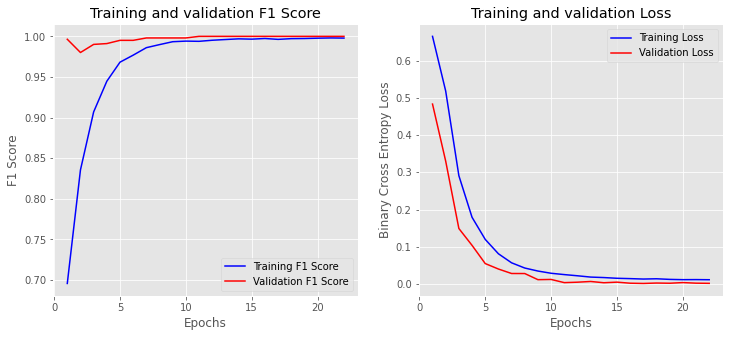

In [ ]:
plot_history(model_fit)

Training F1 Score: 0.9536
Validation F1 Score:  0.7892
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       471
           1       0.80      0.78      0.79       409

    accuracy                           0.81       880
   macro avg       0.80      0.80      0.80       880
weighted avg       0.81      0.81      0.81       880



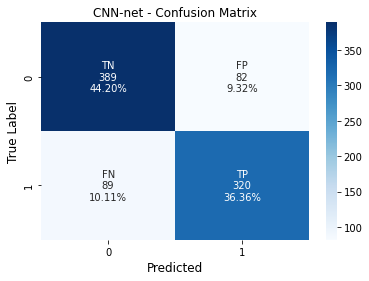

In [ ]:
# Find train and test f1
loss, f1 = model.evaluate(X_train, y_mys_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val, y_mys_val, verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

y_prob = model.predict(X_val)
y_pred_mys = y_prob.round()
                    
print(classification_report(y_mys_val, y_pred_mys))
confusion_matrix(y_mys_val, y_pred_mys)

cf_matrix = confusion_matrix(y_mys_val, y_pred_mys)
make_confusion_matrix(cf_matrix, 'CNN-net - Confusion Matrix')

In [ ]:
model_fit = model.fit(X_train, y_agr_train,
            validation_split = 0.1,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, callbacks=[earlyStopper])

Epoch 1/50
25/25 [==============================] - 3s 47ms/step - loss: 0.6573 - f1_score: 0.0262 - val_loss: 0.6573 - val_f1_score: 0.0000e+00
Epoch 2/50
25/25 [==============================] - 1s 32ms/step - loss: 0.5945 - f1_score: 0.0000e+00 - val_loss: 0.5941 - val_f1_score: 0.0000e+00
Epoch 3/50
25/25 [==============================] - 1s 29ms/step - loss: 0.4876 - f1_score: 0.3672 - val_loss: 0.5052 - val_f1_score: 0.6259
Epoch 4/50
25/25 [==============================] - 1s 36ms/step - loss: 0.3644 - f1_score: 0.8035 - val_loss: 0.4505 - val_f1_score: 0.6682
Epoch 5/50
25/25 [==============================] - 1s 36ms/step - loss: 0.2699 - f1_score: 0.8686 - val_loss: 0.4346 - val_f1_score: 0.6999
Epoch 6/50
25/25 [==============================] - 1s 36ms/step - loss: 0.2013 - f1_score: 0.9047 - val_loss: 0.4452 - val_f1_score: 0.7037
Epoch 7/50
25/25 [==============================] - 1s 34ms/step - loss: 0.1604 - f1_score: 0.9251 - val_loss: 0.4615 - val_f1_score: 0.7013
E

Training F1 Score: 0.9285
Validation F1 Score:  0.4916
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       566
           1       0.59      0.44      0.50       314

    accuracy                           0.69       880
   macro avg       0.66      0.63      0.64       880
weighted avg       0.68      0.69      0.68       880



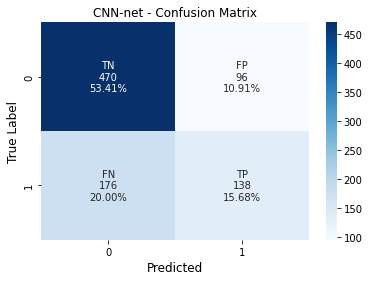

In [ ]:
# Find train and test f1
loss, f1 = model.evaluate(X_train, y_agr_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val, y_agr_val, verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

y_prob = model.predict(X_val)
y_pred = y_prob.round()
                    
print(classification_report(y_agr_val, y_pred))
confusion_matrix(y_agr_val, y_pred)

cf_matrix = confusion_matrix(y_agr_val, y_pred)
make_confusion_matrix(cf_matrix, 'CNN-net - Confusion Matrix')

Training F1 Score: 0.9285
Validation F1 Score:  0.5785
              precision    recall  f1-score   support

           0       0.40      0.42      0.41       161
           1       0.60      0.57      0.58       241

    accuracy                           0.51       402
   macro avg       0.50      0.50      0.50       402
weighted avg       0.52      0.51      0.51       402



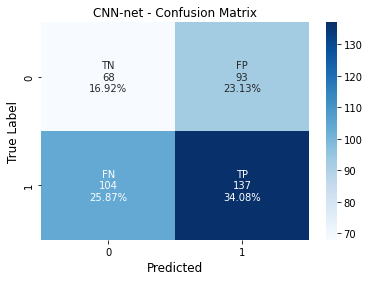

In [ ]:
## second testing strategy
itemindex = np.where(y_pred_mys == 1)
X_val_agr = X_val[itemindex[0]]
y_prob = model.predict(X_val_agr)
y_pred_agr = y_prob.round()
y_agr_val.reset_index(inplace=True, drop=True)                    

# Find train and test f1
loss, f1 = model.evaluate(X_train, y_agr_train, verbose=False)
print("Training F1 Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val_agr, y_agr_val[itemindex[0]], verbose=False)
print("Validation F1 Score:  {:.4f}".format(f1))

print(classification_report(y_agr_val[itemindex[0]], y_pred_agr))
confusion_matrix(y_agr_val[itemindex[0]], y_pred_agr)

cf_matrix = confusion_matrix(y_agr_val[itemindex[0]], y_pred_agr)

make_confusion_matrix(cf_matrix, 'CNN-net - Confusion Matrix')

In [ ]:
tokenizer,X_train,X_val,y_mys_train,y_mys_val, y_agr_train, y_agr_val, y_mlc_train, y_mlc_val = split_tokenize_padding(df,True)

In [ ]:
y_mlc_train = to_categorical(y_mlc_train, num_classes=3)
y_mlc_val = to_categorical(y_mlc_val, num_classes=3)

In [ ]:
model = build_cnn_bench(3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           819600    
                                                                 
 conv1d_1 (Conv1D)           (None, 33, 32)            9632      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 32)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 32)            0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 classifier (Dense)          (None, 3)                 1539      
                                                      

In [ ]:
model_fit = model.fit(X_train, y_mlc_train,
            validation_split = 0.1,
            batch_size=BATCH_SIZE,
            epochs=30, callbacks=[earlyStopper])

Epoch 1/30
25/25 [==============================] - 2s 45ms/step - loss: 0.9760 - acc: 0.5360 - val_loss: 0.9405 - val_acc: 0.5085
Epoch 2/30
25/25 [==============================] - 1s 30ms/step - loss: 0.8548 - acc: 0.6318 - val_loss: 0.8250 - val_acc: 0.6392
Epoch 3/30
25/25 [==============================] - 1s 35ms/step - loss: 0.6641 - acc: 0.7547 - val_loss: 0.6572 - val_acc: 0.7216
Epoch 4/30
25/25 [==============================] - 1s 28ms/step - loss: 0.4868 - acc: 0.8240 - val_loss: 0.5962 - val_acc: 0.7443
Epoch 5/30
25/25 [==============================] - 1s 32ms/step - loss: 0.3914 - acc: 0.8480 - val_loss: 0.5838 - val_acc: 0.7472
Epoch 6/30
25/25 [==============================] - 1s 35ms/step - loss: 0.3227 - acc: 0.8663 - val_loss: 0.5857 - val_acc: 0.7500
Epoch 7/30
25/25 [==============================] - 1s 37ms/step - loss: 0.2724 - acc: 0.8815 - val_loss: 0.5965 - val_acc: 0.7443
Epoch 8/30
25/25 [==============================] - 1s 48ms/step - loss: 0.2279 - a

In [ ]:
# Find train and test f1
loss, f1 = model.evaluate(X_train, y_mlc_train, verbose=False)
print("Training Accuracy Score: {:.4f}".format(f1))
loss, f1 = model.evaluate(X_val, y_mlc_val, verbose=False)
print("Validation Accuracy Score:  {:.4f}".format(f1))

y_prob = model.predict(X_val)
y_pred = y_prob.round()

print(classification_report(y_mlc_val, y_pred))

Training Accuracy Score: 0.8515
Validation Accuracy Score:  0.7102
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       471
           1       0.26      0.29      0.28        95
           2       0.59      0.85      0.69       314

   micro avg       0.62      0.81      0.71       880
   macro avg       0.52      0.68      0.59       880
weighted avg       0.62      0.81      0.70       880
 samples avg       0.68      0.81      0.72       880

